In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
here = os.getcwd()
temp = here.split("\\")
home = '\\'.join(temp[:-2])

In [3]:
df = pd.read_csv(os.path.join(home, 'Label_GUI/All files labelling/output_labeling/label_file560.csv'))

# Extract the time, value, and mask columns
time = df['time'].to_numpy()
value = df['value'].to_numpy()
mask = df['finalLabel'].to_numpy()

# Separate the mask into positive and negative classes
positive_mask = np.where(mask == 1, value, np.nan)
negative_mask = np.where(mask == -1, value, np.nan)

In [4]:
def grouping(arr):
    if arr is None: 
        return []

    inter_arr = []
    main_arr = []
    inter_arr.append(arr[0])
    csd = arr[0]
    for candidate in arr[1:]:
        if candidate - csd <=1:
            inter_arr.append(candidate)
        else:
            main_arr.append(inter_arr)
            inter_arr= [candidate]
        csd = candidate
    if len(inter_arr) >0:
        main_arr.append(inter_arr)
    return main_arr


In [42]:
from features_define import FeatureDefine

# input is position of instance, output is 8 feature
def compute_feature(value,indexx, df):
    # print(f' value {value}, index is {indexx}')
    if indexx is not None:
        for ins in indexx:
            workingOn = FeatureDefine(value[ins])
            euclid_distance= workingOn.fe_dist()
            vertical_margin_diff= workingOn.margin_diff()
            peakProp= workingOn.peakProp()
            left_slope, mid_slope, right_slope= workingOn.slope()
            left_ellipse_prop= workingOn.ellipse_prop(workingOn.ellipse_left[1],workingOn.left_list) # 1 la index cua radii
            right_ellipse_prop= workingOn.ellipse_prop(workingOn.ellipse_right[1],workingOn.right_list)
            standard_deviation= workingOn.standard_deviation()

            new_row_df = pd.DataFrame([[euclid_distance,vertical_margin_diff,
                                        peakProp, left_slope, 
                                        mid_slope, right_slope,
                                        left_ellipse_prop, right_ellipse_prop, standard_deviation]], columns=df.columns)
            df = pd.concat([df, new_row_df],ignore_index=True)
        
    return df
            

In [74]:
def process_csv_files(folder_path):

    true_instance_list = pd.DataFrame(columns=['euclid_distance','vertical_margin_diff','peakdiffProp','left_slope','mid_slope','right_slope',
                                  'left_ellipse_prop','right_ellipse_prop','standard_deviation'])
    
    false_instance_list = pd.DataFrame(columns=['euclid_distance','vertical_margin_diff','peakdiffProp','left_slope','mid_slope','right_slope',
                                  'left_ellipse_prop','right_ellipse_prop','standard_deviation'])

    # Check if folder_path exists and is a directory
    if not os.path.exists(folder_path) or not os.path.isdir(folder_path):
        raise FileNotFoundError(f"The folder '{folder_path}' does not exist or is not a directory.")
    
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            try:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(file_path)
                
                # Ensure the necessary columns exist
                if not {'time', 'value', 'finalLabel'}.issubset(df.columns):
                    raise ValueError(f"The file '{filename}' does not contain the required columns.")
                
                # Extract the time, value, and mask columns
                value = df['value'].to_numpy()
                mask = df['finalLabel'].to_numpy()
                
                # Separate the mask into positive and negative classes
                
                positive_mask = np.where(mask == 1)[0]
                negative_mask = np.where(mask == -1)[0]
            
                positive_gr_index = grouping(positive_mask)
                negative_gr_index = grouping(negative_mask)

                true_instance_list = compute_feature(value, positive_gr_index, true_instance_list)

                false_instance_list = compute_feature(value, negative_gr_index, false_instance_list)
                # print('====================================================')
                # print(f'this is positive index instances {positive_gr_index}, array is none : {len(positive_gr_index)}')
                # print()
                # print(f'this is negave index instances {negative_gr_index}, array is none : {len(negative_gr_index)}')

            except pd.errors.EmptyDataError:
                print(f"Warning: The file '{filename}' is empty and has been skipped.")
            except pd.errors.ParserError:
                print(f"Warning: The file '{filename}' could not be parsed and has been skipped.")
            except Exception as e:
                print(f"Warning: An error occurred while processing the file '{filename}': {e}")

    true_instance_list.to_csv(os.path.join(home,'truePositive.csv'), index=False)
    false_instance_list.to_csv(os.path.join(home,'falsePositive.csv'),index= False)

# Example usage
folder_path = os.path.join(home,'Label_GUI\All files labelling\output_labeling')
process_csv_files(folder_path)

C:\Users\Tan Duong\AppData\Local\Temp\ipykernel_22136\1252121923.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row_df],ignore_index=True)


In [75]:
faslePositive = pd.read_csv(os.path.join(home, 'falsePositive.csv'))
truePositive = pd.read_csv(os.path.join(home, 'truePositive.csv'))


In [76]:
truePositive.describe()

,euclid_distance,vertical_margin_diff,peakdiffProp,left_slope,mid_slope,right_slope,left_ellipse_prop,right_ellipse_prop,standard_deviation
count,4970.000000,4970.000000,4970.000000,4970.000000,4970.000000,4970.000000,4970.000000,4970.000000,4970.000000
mean,0.603387,0.042697,0.996293,0.196122,-0.098059,2.833635,0.281354,0.294873,0.776854
std,0.256295,0.083378,0.136633,0.131912,0.086680,0.288536,0.182785,0.145957,0.520546
min,0.241177,0.000000,0.385671,0.012234,-0.865633,-3.129974,0.000119,0.002681,0.083097
25%,0.440225,0.010833,0.917361,0.107261,-0.121330,2.750278,0.150682,0.192609,0.444713
50%,0.540645,0.025329,0.984634,0.163404,-0.072048,2.888200,0.266675,0.273158,0.643953
75%,0.700014,0.050507,1.053293,0.247032,-0.045457,2.984553,0.372285,0.369589,0.903434
max,6.160033,3.375244,2.291625,1.292140,0.187395,3.136913,3.153553,1.651268,3.993875


In [77]:
faslePositive.describe()

,euclid_distance,vertical_margin_diff,peakdiffProp,left_slope,mid_slope,right_slope,left_ellipse_prop,right_ellipse_prop,standard_deviation
count,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000
mean,1.217458,0.134046,1.072426,0.502611,-0.153898,2.406430,0.522364,0.493621,0.538367
std,0.965435,0.340984,0.629311,0.363412,0.207329,0.858507,0.586062,0.346215,0.414724
min,0.229102,0.000000,0.133314,0.006628,-1.499142,-3.139369,0.000266,0.000006,0.038824
25%,0.600969,0.014190,0.901682,0.204223,-0.219266,2.205640,0.188254,0.282874,0.233017
50%,0.920826,0.033264,0.998541,0.408293,-0.092370,2.563042,0.360478,0.440557,0.448426
75%,1.459181,0.078544,1.113458,0.736418,-0.045680,2.839161,0.610076,0.625200,0.722788
max,9.060123,5.401611,34.821513,1.559000,1.299082,3.140070,9.168855,4.841396,3.429060


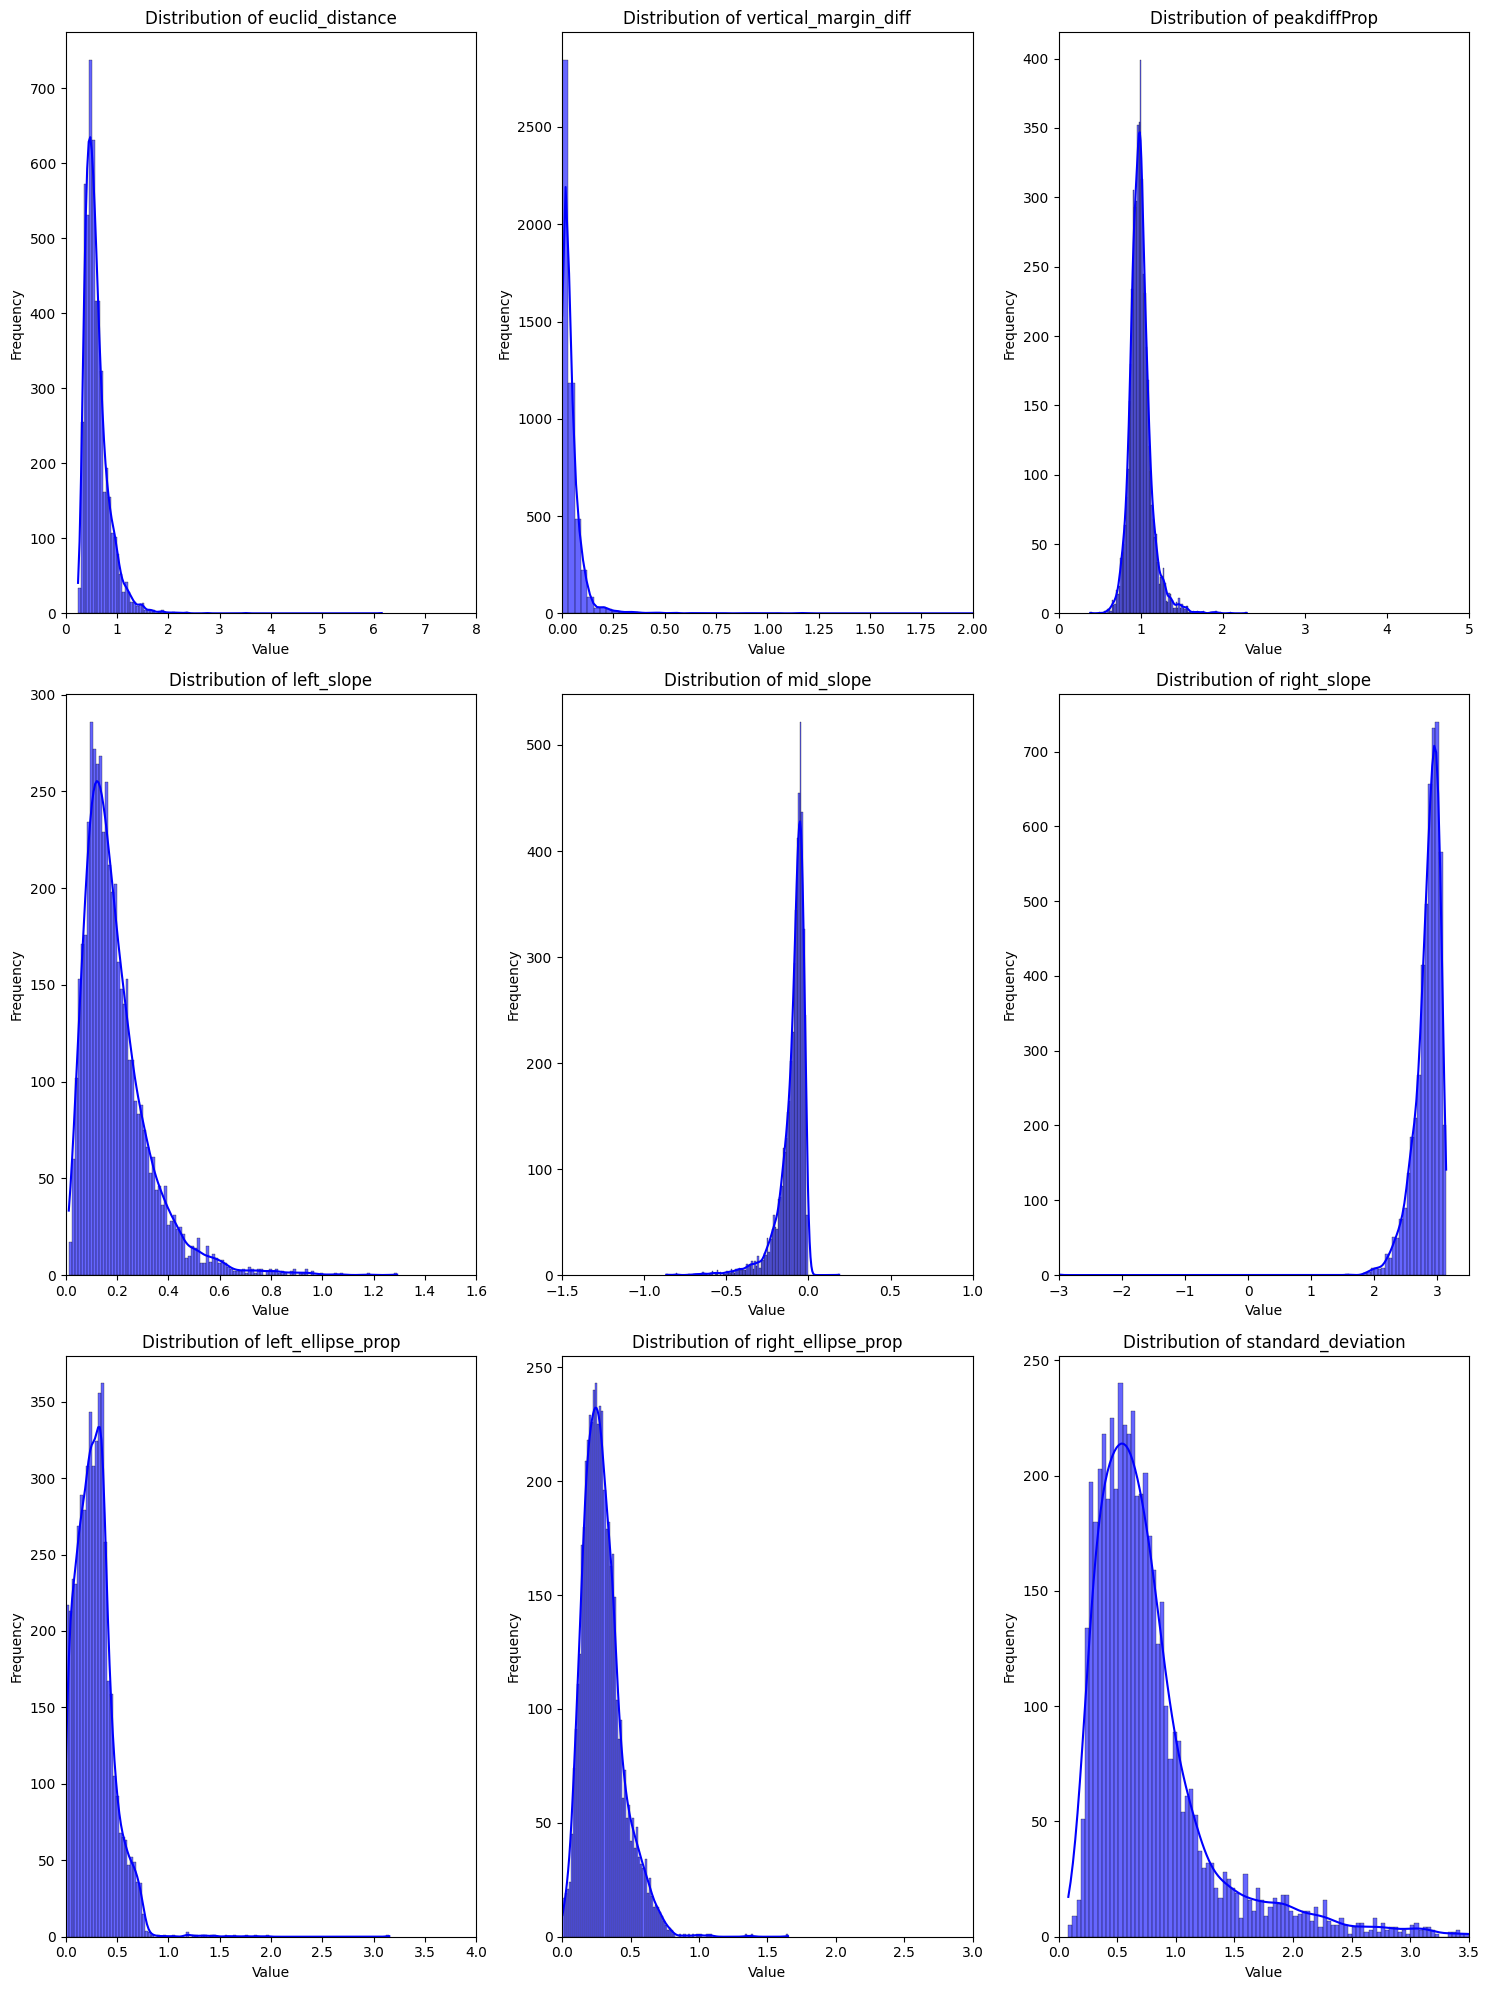

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fields= truePositive.columns

# Plotting the distribution
fig, axes = plt.subplots(3,3, figsize=(15, 20))
axes = axes.flatten()
lim_x = [(0,8.0),(0,2.0),(0,5.0),(0,1.6),(-1.5,1),(-3,3.5),(0,4),(0,3),(0,3.5)]

for i, col in enumerate(fields):
    sns.histplot(truePositive[col], bins=110, kde=True, ax=axes[i], color='blue', alpha=0.6)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(lim_x[i])

plt.tight_layout()
plt.show()

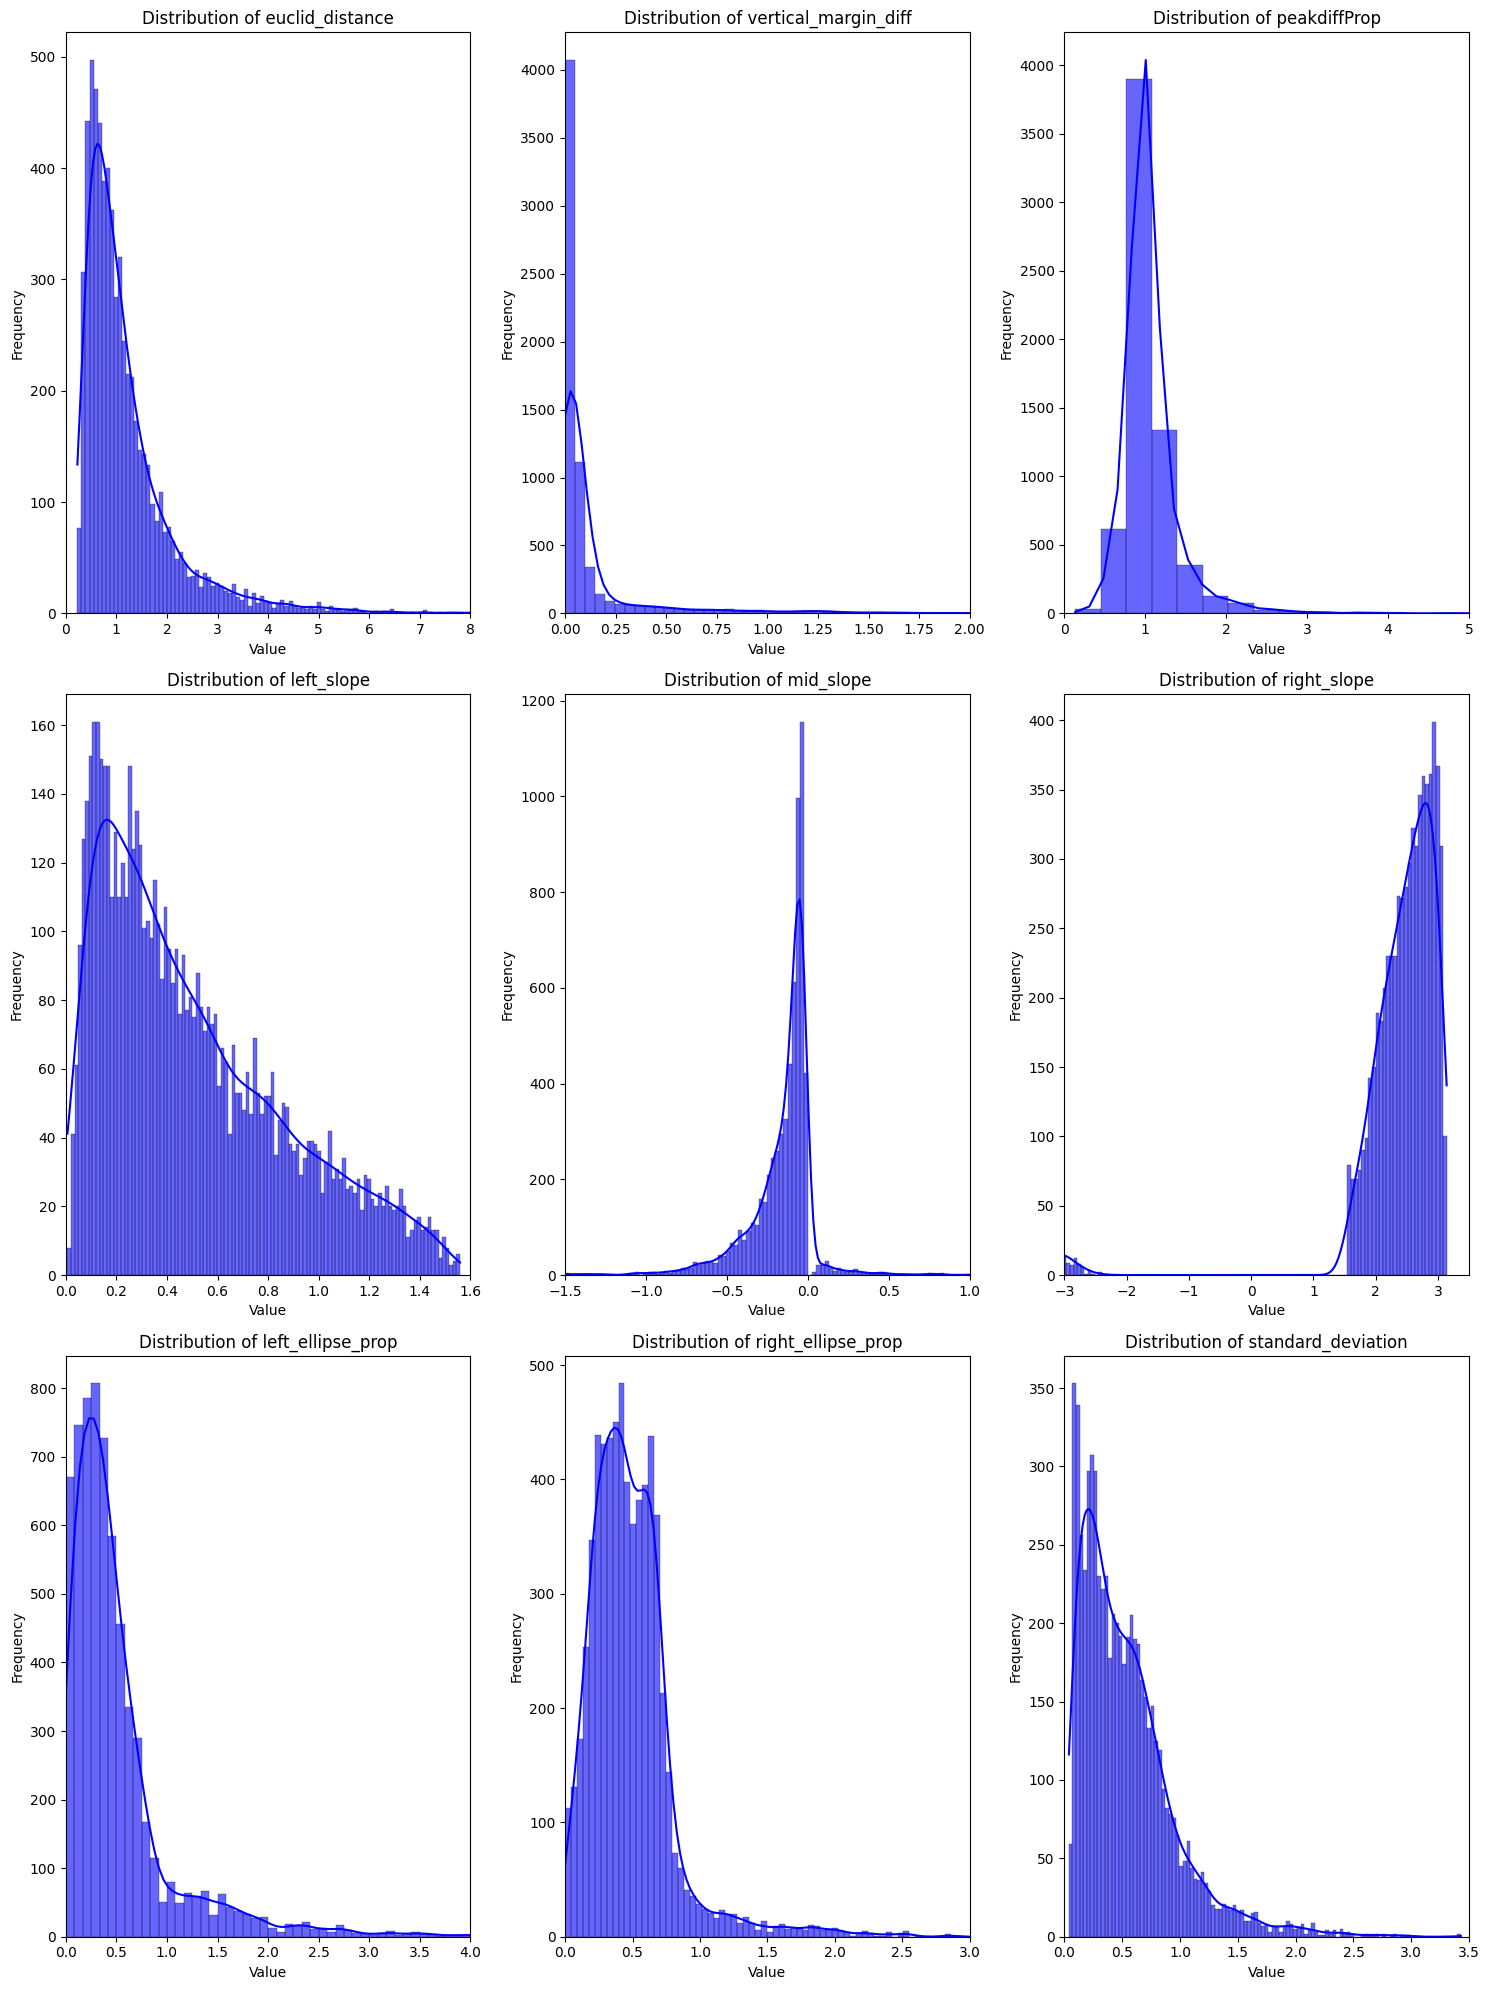

In [73]:
fields= truePositive.columns

# Plotting the distribution
fig, axes = plt.subplots(3,3, figsize=(15, 20))
axes = axes.flatten()
lim_x = [(0,8.0),(0,2.0),(0,5.0),(0,1.6),(-1.5,1),(-3,3.5),(0,4),(0,3),(0,3.5)]

for i, col in enumerate(fields):
    sns.histplot(faslePositive[col], bins=110, kde=True, ax=axes[i], color='blue', alpha=0.6)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(lim_x[i])

plt.tight_layout()
plt.show()

# Framework for trainning

## ===========================================================

## 1, Load data